In [ ]:
#importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
from pmdarima import auto_arima
import pmdarima as pm

from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse

import warnings       
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

!pip install Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data = pd.read_csv('/content/train.csv')
data['date']=pd.to_datetime(data['date'], infer_datetime_format=True)
data=data.set_index(['date'])
data

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [ ]:
store_1_df = data.query('store == 1').loc[:,['sales']]
store_1_df.index.year

Int64Index([2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='date', length=91300)

In [ ]:
store_1_df.iloc[:31,:]['sales']

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
2013-01-06    12
2013-01-07    10
2013-01-08     9
2013-01-09    12
2013-01-10     9
2013-01-11     9
2013-01-12     7
2013-01-13    10
2013-01-14    12
2013-01-15     5
2013-01-16     7
2013-01-17    16
2013-01-18     7
2013-01-19    18
2013-01-20    15
2013-01-21     8
2013-01-22     7
2013-01-23     9
2013-01-24     8
2013-01-25    14
2013-01-26    12
2013-01-27    12
2013-01-28    11
2013-01-29     6
2013-01-30     9
2013-01-31    13
Name: sales, dtype: int64

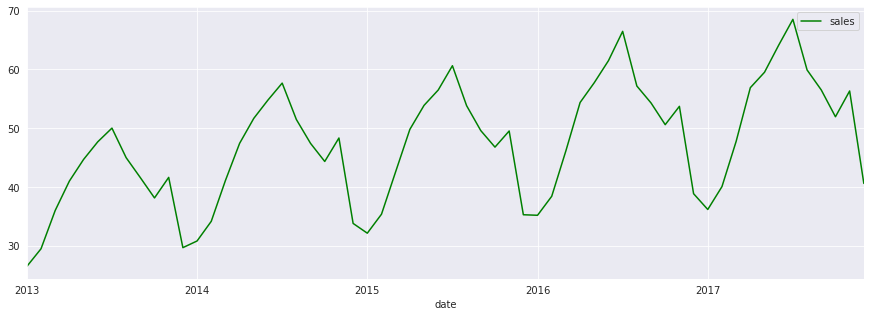

In [ ]:
#monthly mean sales begin
monthlysales_mean = pd.DataFrame(store_1_df.resample(rule='MS').mean()['sales'])

monthlysales_mean.plot(figsize=(15,5),c='green')
plt.show()

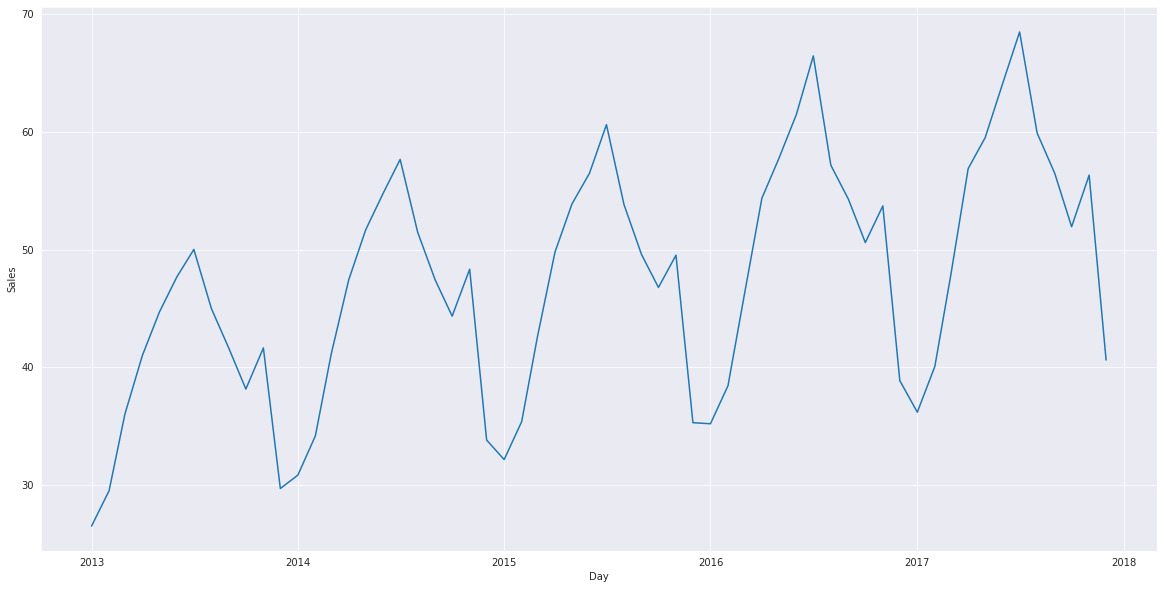

In [ ]:
# plotting time vs sales
plt.figure(figsize=(20,10))
plt.xlabel("Day")
plt.ylabel("Sales")
plt.plot(monthlysales_mean)

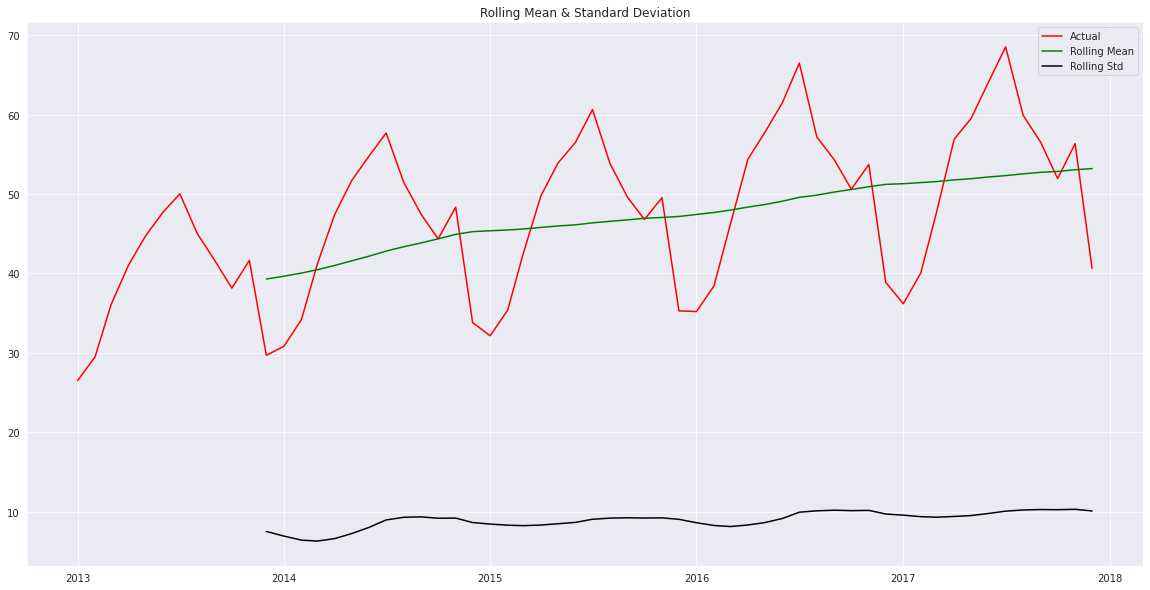

In [ ]:
# checking whether trends exist
rolmean = monthlysales_mean.rolling(window=12).mean()
rolstd = monthlysales_mean.rolling(window=12).std()

# plotting moving average
plt.figure(figsize=(20,10))
actual=plt.plot(monthlysales_mean, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Trend exist (upward trend)

 Null hypothesis - Time Series is non-stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):
    
    # using rolling stats
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(20,10))
    actual = plt.plot(timeseries, color='red', label='Actual')
    mean_6 = plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6 = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # using ADF test
    print('Dickey-Fuller Test: ')
    dftest = adfuller(timeseries['sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

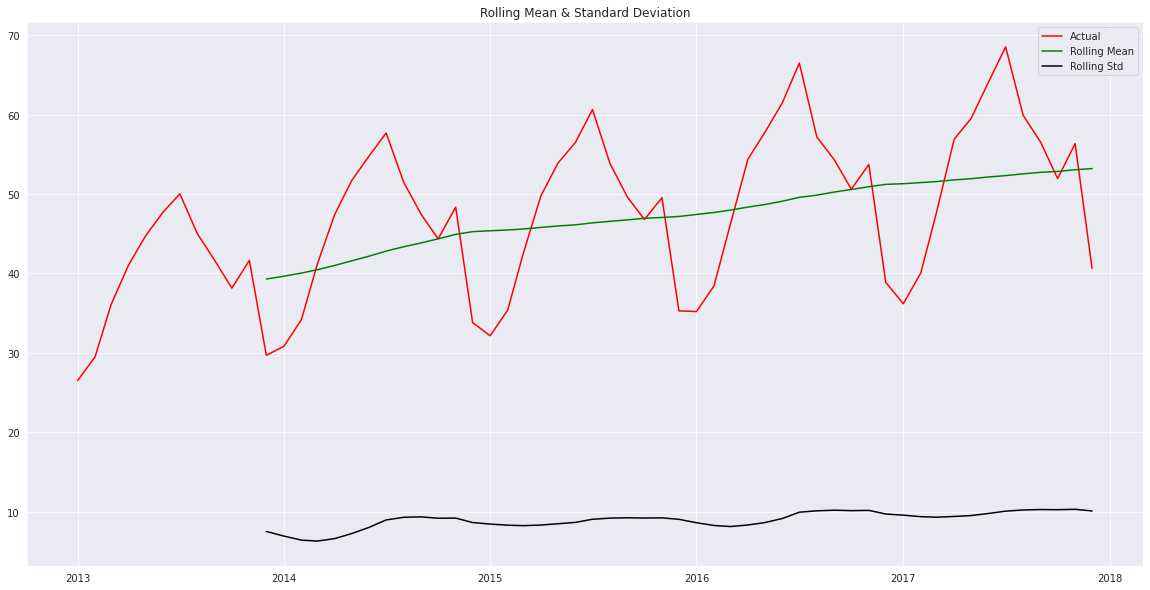

Dickey-Fuller Test: 
Test Statistic          -5.165600
p-value                  0.000010
Lags Used               11.000000
No. of Obs              48.000000
Critical Value (1%)     -3.574589
Critical Value (5%)     -2.923954
Critical Value (10%)    -2.600039
dtype: float64


In [ ]:
# checking whether stationarity exist or not
check_stationarity(monthlysales_mean)

Here the p-value < 0.5, Therefore we reject the null hypothesis. Hence stationarity exist

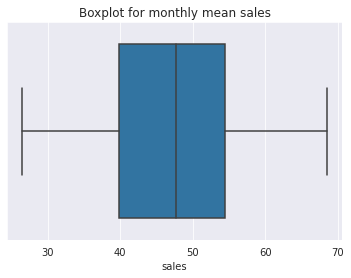

In [ ]:
# checking for outliers
plt.title('Boxplot for monthly mean sales')
sns.boxplot(monthlysales_mean.sales)
plt.show()

No outliers present in the data

Decomposing Time Series into its components : Trend, Seasonality and Residual

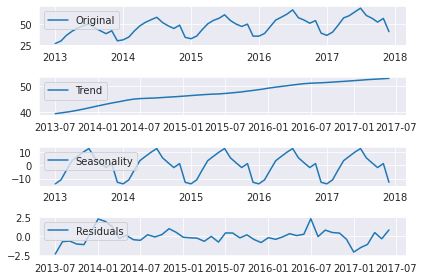

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(monthlysales_mean)

trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

plt.subplot(411)
plt.plot(monthlysales_mean, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Autocorrelation and Partial Autocorrelation plots

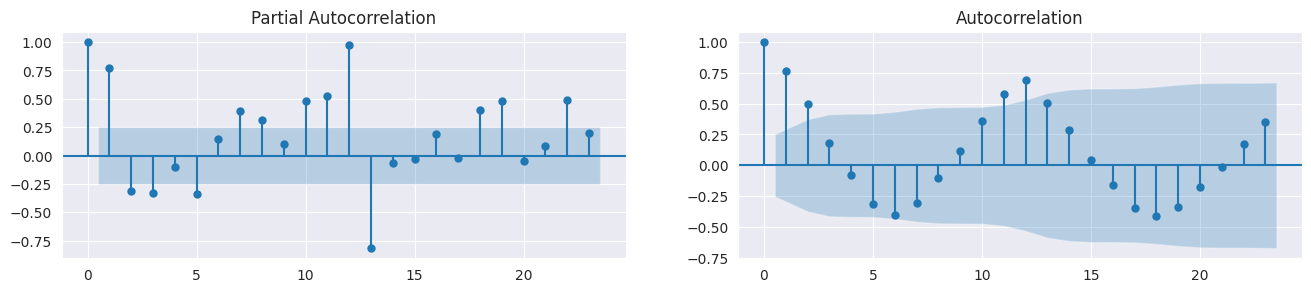

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(monthlysales_mean.sales,lags=23,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(monthlysales_mean.sales, lags=23,ax=axes[1])
plt.show()

# Parameter selection (using auto_arima)

In [ ]:
# ARIMA - AR(p), I(d), MA(q)
# SARIMAX - P (Seasonal regression), D (Differencing), Q(Moving average coefficients), m (no. of data points in each seasonal cycle)

In [ ]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(monthlysales_mean.sales, 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

Model Diagnosis

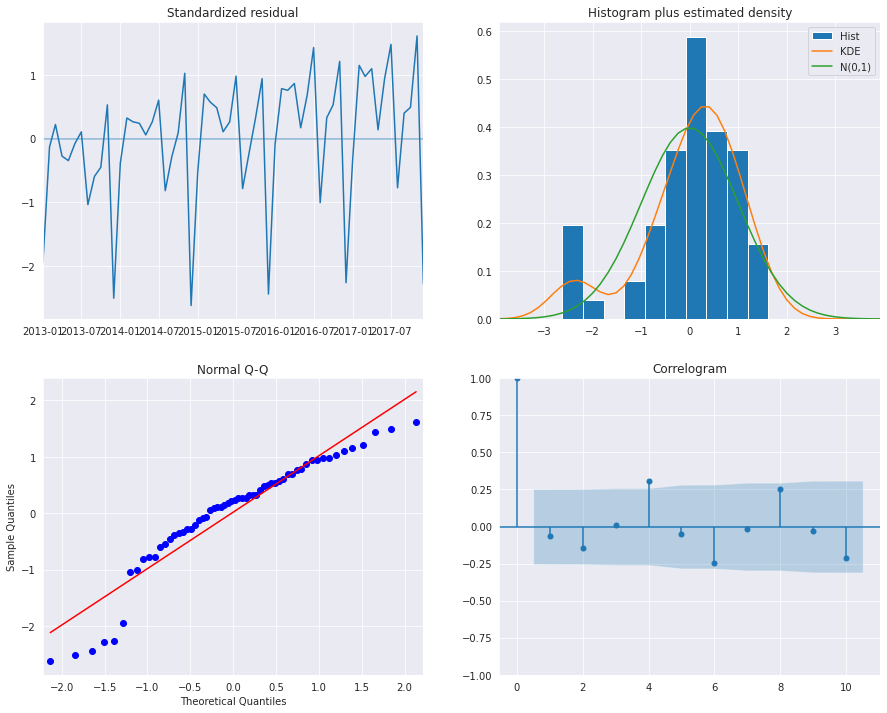

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

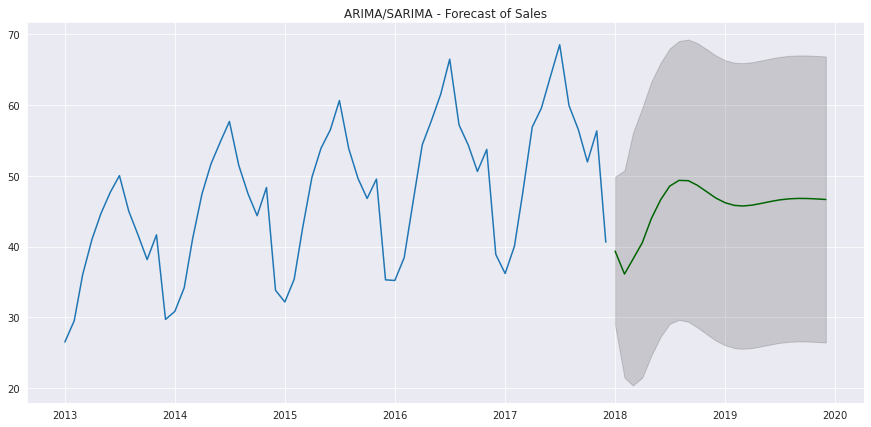

In [ ]:
# forecast using ARIMA model
def forecast(model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(monthlysales_mean.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(monthlysales_mean.sales['2013':'2017'], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Sales")
    plt.show()

forecast(ARIMA_model)

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(monthlysales_mean.sales, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Forecasting

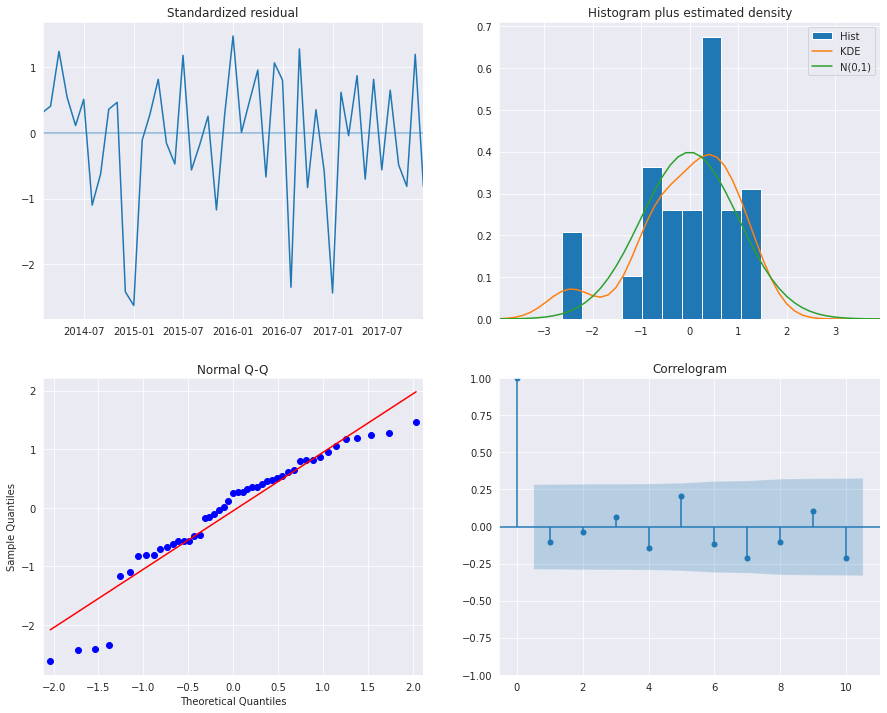

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

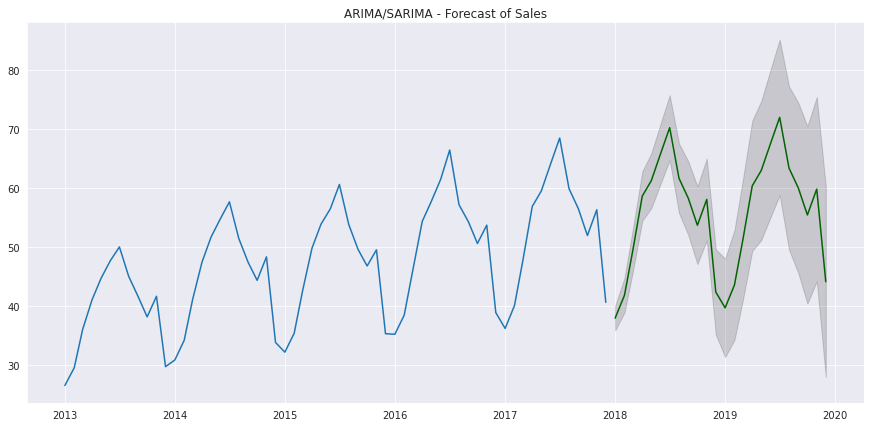

In [ ]:
forecast(SARIMA_model)

In [ ]:
#adding exogenous variable
monthlysales_mean['month_index'] = monthlysales_mean.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(monthlysales_mean.sales, exogenous=monthlysales_mean[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

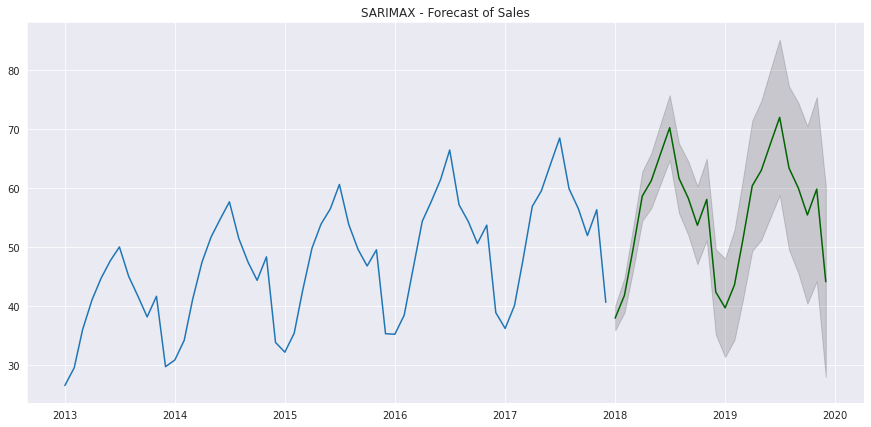

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(monthlysales_mean.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(monthlysales_mean.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(monthlysales_mean.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(monthlysales_mean.sales, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Sales")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)

Parameter Selection (based on lowest AIC score)

In [ ]:
monthlysales_mean.sales['2013':'2016']

date
2013-01-01    26.501290
2013-02-01    29.504286
2013-03-01    36.017419
2013-04-01    41.015333
2013-05-01    44.691613
2013-06-01    47.687333
2013-07-01    50.017419
2013-08-01    44.996774
2013-09-01    41.605333
2013-10-01    38.148387
2013-11-01    41.643333
2013-12-01    29.696129
2014-01-01    30.830968
2014-02-01    34.170000
2014-03-01    41.115484
2014-04-01    47.432667
2014-05-01    51.682581
2014-06-01    54.797333
2014-07-01    57.670323
2014-08-01    51.480000
2014-09-01    47.422667
2014-10-01    44.348387
2014-11-01    48.337333
2014-12-01    33.816129
2015-01-01    32.156129
2015-02-01    35.378571
2015-03-01    42.616774
2015-04-01    49.800667
2015-05-01    53.885806
2015-06-01    56.496667
2015-07-01    60.625161
2015-08-01    53.833548
2015-09-01    49.592667
2015-10-01    46.787097
2015-11-01    49.528000
2015-12-01    35.290968
2016-01-01    35.199355
2016-02-01    38.428966
2016-03-01    46.170968
2016-04-01    54.371333
2016-05-01    57.743226
2016-06-01 

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
simple_pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]

print('Parameter combinations for Seasonal ARIMA...')

for param in simple_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthlysales_mean.sales['2013':'2016'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)


            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Parameter combinations for Seasonal ARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:497.35774238733467
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1453.662469689543
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:204.88437392302706
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:118.53703588773509
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:154.4257300392115
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1078.7091000334954
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:113.84809248950032
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:102.99094743583031
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:436.9641612716639
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2431.783988419411
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:161.19436825485872
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:94.37989993080411
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:124.39248713744372
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2018.9985467304634
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:95.36534216859869
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:83.74647999139141
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:298.3935694412976
ARIMA(0, 1,

In [ ]:
best_model = SARIMAX(monthlysales_mean.sales, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
print(best_model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1906      0.123     -1.548      0.122      -0.432       0.051
ar.S.L12      -0.9987      0.510     -1.957      0.050      -1.999       0.001
ma.S.L12       0.9675      6.331      0.153      0.879     -11.441      13.376
sigma2         0.8484      4.802      0.177      0.860      -8.563      10.260


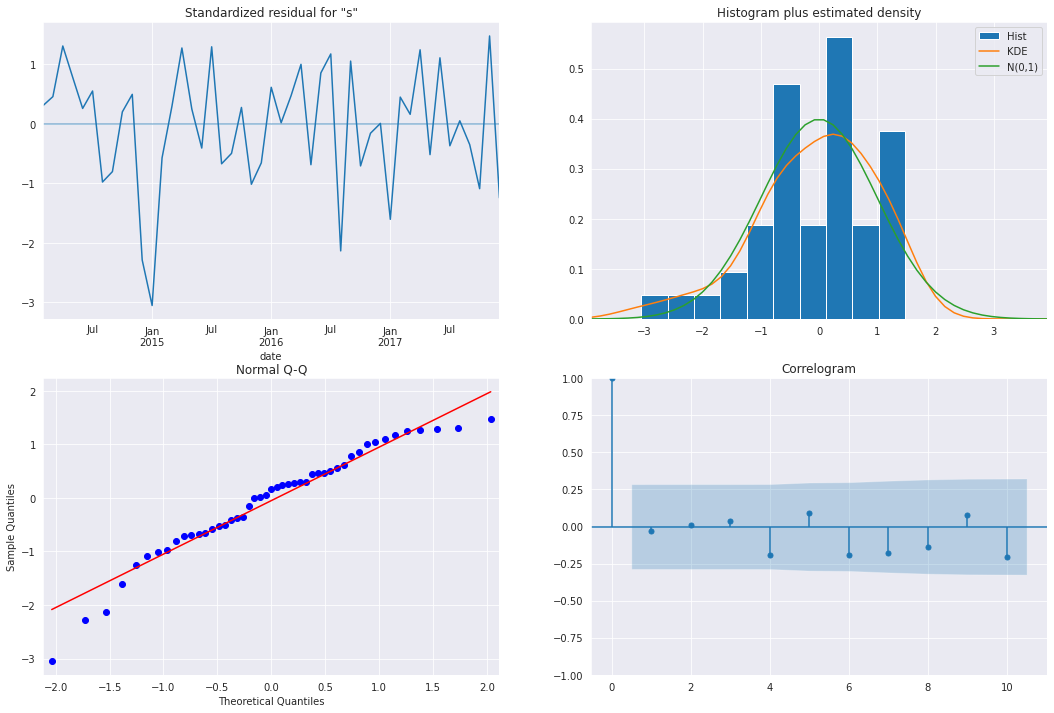

In [ ]:
best_model.plot_diagnostics(figsize=(18, 12))
plt.show()

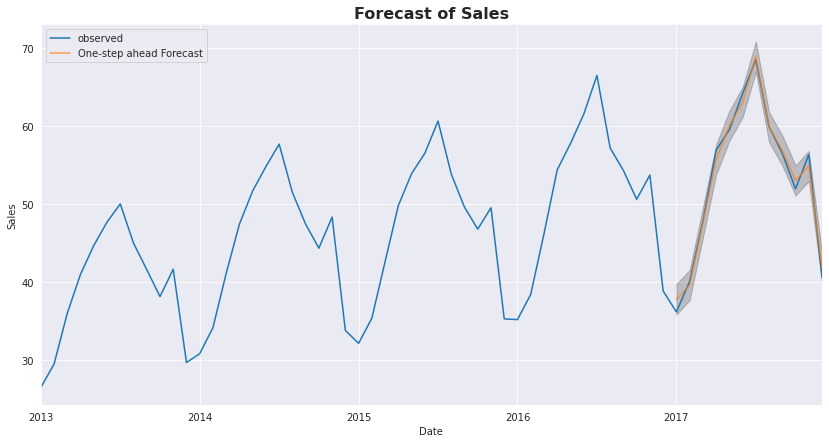

In [ ]:
pred = best_model.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = monthlysales_mean.sales['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Forecast of Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [ ]:
pred.predicted_mean

date
2017-01-01    37.795820
2017-02-01    39.625951
2017-03-01    47.607954
2017-04-01    55.663465
2017-05-01    60.025763
2017-06-01    63.029838
2017-07-01    68.871820
2017-08-01    59.856420
2017-09-01    56.851591
2017-10-01    53.023825
2017-11-01    54.875066
2017-12-01    41.848392
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = monthlysales_mean.sales['2016-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.89
The Root Mean Squared Error of our forecasts is 0.94


In [ ]:
y_forecasted = pred.predicted_mean
y_truth = monthlysales_mean.sales['2017-01-01']

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 377.86
The Root Mean Squared Error of our forecasts is 19.44


In [ ]:
# Forecasting using Prophet

In [ ]:
monthly_sales = monthlysales_mean.sales.to_frame()
monthly_sales['date'] = monthly_sales.index
monthly_sales.columns = ['y','ds']
monthly_sales

,y,ds
date,,
2013-01-01,26.501290,2013-01-01
2013-02-01,29.504286,2013-02-01
2013-03-01,36.017419,2013-03-01
2013-04-01,41.015333,2013-04-01
2013-05-01,44.691613,2013-05-01
2013-06-01,47.687333,2013-06-01
2013-07-01,50.017419,2013-07-01
2013-08-01,44.996774,2013-08-01
2013-09-01,41.605333,2013-09-01


In [ ]:
prophet_model = Prophet()

prophet_model.fit(monthly_sales)

future_date = prophet_model.make_future_dataframe(periods=24,freq='MS')

future_date

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1a9lf2ot/xbaubazz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1a9lf2ot/9j9hlwqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25660', 'data', 'file=/tmp/tmp1a9lf2ot/xbaubazz.json', 'init=/tmp/tmp1a9lf2ot/9j9hlwqn.json', 'output', 'file=/tmp/tmp1a9lf2ot/prophet_modelxc8otpef/prophet_model-20230226164944.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:49:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:49:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
0,2013-01-01
1,2013-02-01
2,2013-03-01
3,2013-04-01
4,2013-05-01
...,...
79,2019-08-01
80,2019-09-01
81,2019-10-01
82,2019-11-01


In [ ]:
forecasted_sales = prophet_model.predict(future_date)
forecasted_sales

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,37.494767,23.014415,25.991760,37.494767,37.494767,-13.045499,-13.045499,-13.045499,-13.045499,-13.045499,-13.045499,0.0,0.0,0.0,24.449268
1,2013-02-01,37.894276,26.555105,29.352891,37.894276,37.894276,-9.972418,-9.972418,-9.972418,-9.972418,-9.972418,-9.972418,0.0,0.0,0.0,27.921858
2,2013-03-01,38.255123,33.500812,36.379777,38.255123,38.255123,-3.351210,-3.351210,-3.351210,-3.351210,-3.351210,-3.351210,0.0,0.0,0.0,34.903913
3,2013-04-01,38.654632,40.776364,43.792818,38.654632,38.654632,3.632691,3.632691,3.632691,3.632691,3.632691,3.632691,0.0,0.0,0.0,42.287323
4,2013-05-01,39.041254,44.374712,47.228358,39.041254,39.041254,6.774221,6.774221,6.774221,6.774221,6.774221,6.774221,0.0,0.0,0.0,45.815475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2019-08-01,59.691701,64.641125,67.765238,59.350016,60.029701,6.498270,6.498270,6.498270,6.498270,6.498270,6.498270,0.0,0.0,0.0,66.189971
80,2019-09-01,59.941365,60.299850,63.321472,59.574855,60.313882,1.849248,1.849248,1.849248,1.849248,1.849248,1.849248,0.0,0.0,0.0,61.790613
81,2019-10-01,60.182975,57.236079,60.296303,59.792301,60.588434,-1.357313,-1.357313,-1.357313,-1.357313,-1.357313,-1.357313,0.0,0.0,0.0,58.825662
82,2019-11-01,60.432639,60.519361,63.620484,60.017465,60.860867,1.610514,1.610514,1.610514,1.610514,1.610514,1.610514,0.0,0.0,0.0,62.043153


In [ ]:
forecasted_sales.iloc[:, [0,2,3,-1]]

,ds,yhat_lower,yhat_upper,yhat
0,2013-01-01,23.014415,25.991760,24.449268
1,2013-02-01,26.555105,29.352891,27.921858
2,2013-03-01,33.500812,36.379777,34.903913
3,2013-04-01,40.776364,43.792818,42.287323
4,2013-05-01,44.374712,47.228358,45.815475
...,...,...,...,...
79,2019-08-01,64.641125,67.765238,66.189971
80,2019-09-01,60.299850,63.321472,61.790613
81,2019-10-01,57.236079,60.296303,58.825662
82,2019-11-01,60.519361,63.620484,62.043153


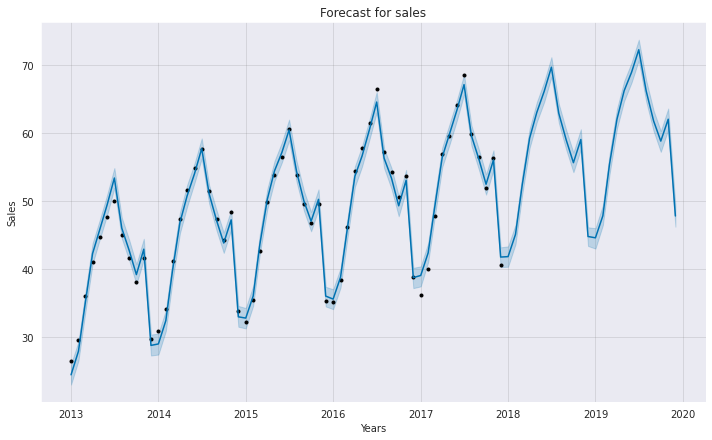

In [ ]:
prophet_model.plot(forecasted_sales)
plt.title('Forecast for sales')
plt.xlabel('Years')
plt.ylabel('Sales')
plt.show()